In [1]:
import os
import librosa
import math
import numpy as np
import scipy
from scipy import linalg
import soundfile as sf
import soundfile
import pyworld as pw
from dtw import dtw
import numpy as np
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import SparseCoder


def split(x):
    m = len(x)//2
    return x[:m], x[m:]

def stft(x):
    y, sr = librosa.load(x, dtype= np.double, sr = 16000)
    spectrogram = librosa.stft(y, n_fft = 32, hop_length = 16)
    abs_val = np.abs(spectrogram)
    angle = np.angle(spectrogram)
    return abs_val, angle

def istft_cal(abs_val, angle):
    A = abs_val*(np.cos(angle)+1j*np.sin(angle))
    return librosa.istft(A , hop_length = 16)

def alignment(x, y):
    alignment = dtw(x.T, y.T, keep_internals=True)
    tmp = {}
    for i in range(len(alignment.index1)):
        a = alignment.index1[i]
        if a in tmp:
            tmp[a].append(alignment.index2[i])
        else:
            tmp[a] = [alignment.index2[i]]
    return tmp 

def Assemble(tmp, x, y, yA):
    # assemble x basing on y elements 
    y_ = []
    yA_ = []
    for i in range(len(x[0])):
        y_.append(y[:, tmp[i][0]])
        yA_.append(yA[:, tmp[i][0]])
    y_ = np.array(y_).T
    yA_ = np.array(yA_).T # from y to y_
    return y_, yA_


def SparseCoding(abs_val):
    abs_val = abs_val.T
    dico = DictionaryLearning(n_components=200, alpha=0.1, max_iter = 1, verbose= True)
    D = dico.fit(abs_val).components_
    W = dico.fit_transform(abs_val)
    return D,W


Source, Target = None, None # Assign your Training data set 
(x, xA), (y, yA) = stft(Source),  stft(Target)
print(x.shape, y.shape)
tmp = alignment(x, y)

y_, yA_ = Assemble(tmp, x, y, yA)
abs = np.vstack((x,y_))
angle = np.vstack((xA, yA_))
D, W = SparseCoding(abs)
DA, DW = SparseCoding(angle)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

(17, 3006) (17, 3236)
[dict_learning] .++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++[dict_learning] .++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++[dict_learning] .++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++[dict_learning] .++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [2]:
Source, Target = None, None # Assign your test set 
(x, xA), (y, yA) = stft(Source),  stft(Target)
tmp = alignment(x, y)
y_, yA_ = Assemble(tmp, x, y, yA)
abs = np.vstack((x,y_))
angle = np.vstack((xA, yA_))

In [4]:
x, y = split(abs)
xA, yA = split(angle)
tmp1 = istft_cal(x, xA)
tmp2 = istft_cal(y, xA)
tmp3 = istft_cal(y, yA)
soundfile.write(file= r'./Target.wav', data=tmp1, samplerate=16000)
# soundfile.write(file= r'./generated_with_DTW_orignal_angle.wav', data=tmp2, samplerate=16000)
# soundfile.write(file= r'./generated_with_DTW_self_angle.wav', data=tmp3, samplerate=16000)

In [7]:
def Reconstruct(abs, D):
    A, B = split(D.T)
    A, B = A.T, B.T # English, Indian 
    coder = SparseCoder(
        dictionary=B, transform_algorithm='lasso_lars',
        transform_alpha=1e-10,
    ) 
    W = (coder.transform(abs.T))
    print(W.shape)
    generated = (W @ A).T # Orignal W and Orignal D
    
    return generated

In [98]:
# For checking the basis
def identitical(abs, D):
    A, B = split(D.T)
    A, B = A.T, B.T # English, Indian 
    coder = SparseCoder(
        dictionary=B, transform_algorithm='lasso_lars',
        transform_alpha=1e-10,
    ) 
    W = np.zeros((4,200))
    W[:,0] = 1
    generated = (W @ B).T # Orignal W and Orignal D
    
    return generated

In [8]:
y_ = Reconstruct(y, D)
yA_ = Reconstruct(yA, DA)

(3416, 200)
(3416, 200)


In [31]:
tmp2 = istft_cal(y_, yA_)
soundfile.write(file= r'./generated_SC.wav', data=tmp2, samplerate=16000)

In [189]:
tmp2 = istft_cal(y_, xA)
soundfile.write(file= r'./generated_DTW_SC.wav', data=tmp2, samplerate=16000)

C:\Users\WAICHA~1\AppData\Local\Temp/ipykernel_25140/1161732964.py:21: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=48).
  plot.specgram(signalData,Fs=samplingFrequency)


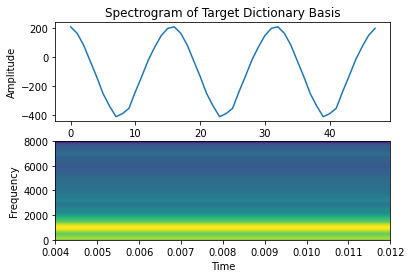

C:\Users\WAICHA~1\AppData\Local\Temp/ipykernel_25140/1161732964.py:48: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=48).
  plot.specgram(signalData,Fs=samplingFrequency)


Text(0, 0.5, 'Frequency')

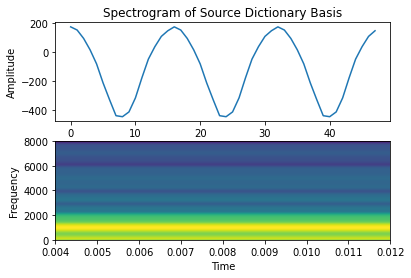

In [103]:
from scipy.io import wavfile 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
y_ = identitical(y, D)
yA_ = identitical(yA, DA)
samplingFrequency, signalData = wavfile.read(r'./IdentiticalA.wav')
plot.subplot(211)

plot.title('Spectrogram of Target Dictionary Basis')

plot.plot(signalData)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

samplingFrequency, signalData = wavfile.read(r'./IdentiticalB.wav')
plot.subplot(211)

plot.title('Spectrogram of Source Dictionary Basis')

plot.plot(signalData)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)

plot.xlabel('Time')

plot.ylabel('Frequency')

 
